In [19]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

## Построение обучающей выборки

In [262]:
b_all = pd.read_csv('./data/baskets_all.csv', engine='python')
b3 = pd.read_csv('./data/baskets_3M.csv', engine='python')
b1 = pd.read_csv('./data/baskets_1M.csv', engine='python')

In [265]:
b_all.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
b3.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
b1.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [266]:
b_all.set_index('id', inplace=True)
b3.set_index('id', inplace=True)
b1.set_index('id', inplace=True)

In [5]:
target = pd.DataFrame({'target': (b1['КоличествоЧеков'] > 0).astype(int)}, index=b1.index)

In [6]:
b3.sample(1)

,КоличествоЧеков,КоличествоЧековВсе,СреднийЧек,СреднееЧислоТоваровЧека,СреднееЧислоТоваровЧекаВсе,Выручка,ВыручкаВся,КоличествоТоваров,КоличествоТоваровВсе,СредняяМаржа,...,SOUTHERN,CENTRAL,PRIVOLZIE,URAL,SIBERIA,FAR EAST,Безналичная,Наличная,Самовывоз,Курьер
id,,,,,,,,,,,,,,,,,,,,,
55574954-53565454575771,1.0,2.0,645.0,1.0,1.0,645.0,1495.0,1.0,2.0,272.66,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [7]:
b1.sample(1)

,КоличествоЧеков,КоличествоЧековВсе,СреднийЧек,СреднееЧислоТоваровЧека,СреднееЧислоТоваровЧекаВсе,Выручка,ВыручкаВся,КоличествоТоваров,КоличествоТоваровВсе,СредняяМаржа,...,SOUTHERN,CENTRAL,PRIVOLZIE,URAL,SIBERIA,FAR EAST,Безналичная,Наличная,Самовывоз,Курьер
id,,,,,,,,,,,,,,,,,,,,,
55574948-52555053565775,1.0,1.0,3350.0,3.0,3.0,3350.0,3350.0,3.0,3.0,223.333333,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [8]:
target.sample(1)

,target
id,
55575351-52495756485173,1


In [9]:
df = b3.merge(target, on='id', how='left').fillna(0)

In [46]:
df = df[df['КоличествоЧековВсе'] > 0]

In [47]:
df.sample(1)

,КоличествоЧеков,КоличествоЧековВсе,СреднийЧек,СреднееЧислоТоваровЧека,СреднееЧислоТоваровЧекаВсе,Выручка,ВыручкаВся,КоличествоТоваров,КоличествоТоваровВсе,СредняяМаржа,...,CENTRAL,PRIVOLZIE,URAL,SIBERIA,FAR EAST,Безналичная,Наличная,Самовывоз,Курьер,target
id,,,,,,,,,,,,,,,,,,,,,
55575653-57545452545672,4.0,4.0,1531.25,3.5,3.5,6125.0,6125.0,14.0,14.0,52.919286,...,0.714286,0.0,0.0,0.0,0.0,0.714286,0.0,0.714286,0.0,1.0


## Разбиваем на трейн и тест

In [48]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Отбор значимых признаков (Lasso)

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso()),
])

search = GridSearchCV(
    pipeline,
    {'model__alpha':np.arange(0.1,1,0.1)},
    scoring="neg_mean_squared_error",
    n_jobs=4,
    verbose=4,
)
search.fit(X_train, y_train)

print('best params:', search.best_params_)

coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
best params: {'model__alpha': 0.1}


In [69]:
X_train.columns[importance > 0]

Index(['КоличествоЧеков'], dtype='object')

In [70]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso()),
])

search = GridSearchCV(
    pipeline,
    {'model__alpha':np.arange(0.05,0.11,0.01)},
    scoring="neg_mean_squared_error",
    n_jobs=4,
    verbose=4,
)
search.fit(X_train, y_train)

print('best params:', search.best_params_)

coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
best params: {'model__alpha': 0.05}


In [71]:
X_train.columns[importance > 0]

Index(['КоличествоЧеков'], dtype='object')

In [72]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso()),
])

search = GridSearchCV(
    pipeline,
    {'model__alpha':np.arange(0.01,0.55,0.005)},
    scoring="neg_mean_squared_error",
    n_jobs=4,
    verbose=4,
)
search.fit(X_train, y_train)

print('best params:', search.best_params_)

coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
best params: {'model__alpha': 0.01}


In [73]:
important_features = X_train.columns[importance > 0]
important_features

Index(['КоличествоЧеков', 'КоличествоЧековВсе', 'КоличествоТоваров',
       'КоличествоТоваровВсе', 'ДоляВыкупленных', 'ИГРУШКИ', 'ППКП',
       'ПОДГУЗНИКИ', 'ПЮРЕ', 'Безналичная', 'Самовывоз'],
      dtype='object')

In [75]:
X_train = X_train[important_features]
X_test = X_test[important_features]
X_train

,КоличествоЧеков,КоличествоЧековВсе,КоличествоТоваров,КоличествоТоваровВсе,ДоляВыкупленных,ИГРУШКИ,ППКП,ПОДГУЗНИКИ,ПЮРЕ,Безналичная,Самовывоз
id,,,,,,,,,,,
55575651-49555351525772,1.0,2.0,5.0,10.0,0.500000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000
55574954-57555650505474,1.0,1.0,1.0,1.0,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000
55574957-57525557555571,2.0,3.0,12.0,26.0,0.461538,0.916667,0.000000,0.000000,0.0,1.000000,1.000000
55575053-48525556554876,1.0,1.0,1.0,1.0,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000
55575452-53534954524971,2.0,2.0,6.0,7.0,0.857143,0.000000,1.000000,0.500000,0.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
55574949-57575257575779,1.0,1.0,10.0,10.0,1.000000,1.000000,0.000000,0.000000,0.0,1.000000,1.000000
55575453-50515356564870,1.0,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000
55575054-49545457545677,1.0,5.0,1.0,9.0,0.125000,0.000000,1.000000,0.000000,0.0,1.000000,1.000000


## Отбор значимых признаков (mutual info)

In [ ]:
# from sklearn.feature_selection import SelectKBest, mutual_info_classif

# mutual_info = mutual_info_classif(X_train, y_train)
# mutual_info = pd.Series(mutual_info, index=X_train.columns)
# plt.rcParams["figure.figsize"] = (24,18)
# mutual_info.plot.bar()
# plt.rcParams["figure.figsize"] = (8,6)

# X_new = SelectKBest(mutual_info_classif, k=42).fit_transform(X_train, y_train)

## Отбор значимых признаков (RFE)

In [ ]:
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression(
#     solver='lbfgs', 
#     max_iter=420,
#     tol=1e-3,
#     n_jobs=4,
# )
# rfe = RFE(model, n_features_to_select=42, step=10)
# fit = rfe.fit(X_train, y_train)

# print("num features: %d" % fit.n_features_)
# print("selected features: %s" % fit.support_)
# print("feature ranking: %s" % fit.ranking_)

In [ ]:
# selected = []
# for i in range(len(X_train.columns)):
#     if fit.support_[i]:
#         selected.append(X_train.columns[i])
# selected

# selected = [
#     'КоличествоЧеков',
#     'ПроцентОтмен',
#     'ППКП',
#     'КГТ',
#     'ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ',
#     'ЗАМЕНИТЕЛИ МОЛОКА',
#     'АКСЕССУАРЫ',
#     'ДЕТСКОЕ БЕЛЬЁ',
#     'ПОДГУЗНИКИ',
#     'ПРЕДМЕТЫ ПО УХОДУ ЗА НОВОРОЖДЕННЫМИ',
#     'БУТЫЛОЧКИ',
#     'БАКАЛЕЯ',
#     'ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет)',
#     'СРЕДСТВА ГИГИЕНЫ',
#     'ПЕЛЕНКИ ОДНОРАЗОВЫЕ',
#     'ГОЛОВНЫЕ УБОРЫ, ВАРЕЖКИ, ПЕРЧАТКИ',
#     'КАШИ',
#     'ПОЛИГРАФИЧЕСКАЯ ПРОДУКЦИЯ',
#     'МЯГКИЕ ИГРУШКИ',
#     'ПЮРЕ',
#     'НАПИТКИ',
#     'ЭЛЕКТРОПРИБОРЫ',
#     'ДЕТСКИЕ КОЛГОТКИ И НОСКИ',
#     'ТОВАРЫ ДЛЯ КОШЕК',
#     'ПОСУДА',
#     'ИЗДЕЛИЯ ИЗ ПЛАСТМАССЫ',
#     'ТРУСИКИ НЕПРОМОКАЕМЫЕ',
#     'КАТАЛКИ/КАЧАЛКИ',
#     'МОЛОКООТСОСЫ',
#     'КОНДИТЕРСКИЕ ИЗДЕЛИЯ',
#     'ПРОДУКТЫ ПИТАНИЯ ДЛЯ МАМ',
#     'МАНЕЖИ/ШЕЗЛОНГИ',
#     'ТОВАРЫ ДЛЯ СОБАК',
#     'ДЕКОР',
#     'АКСЕССУАРЫ ДЛЯ ВОЛОС',
#     'ВСЁ ДЛЯ ПРАЗДНИКА',
#     'ФОТОАЛЬБОМЫ/ФОТОРАМКИ',
#     'САНКИ/СНЕГОКАТЫ',
#     'ОДЕЖДА, ОБУВЬ',
#     'ЭЛЕКТРОМОБИЛИ/МАШИНЫ ПЕДАЛЬНЫЕ',
#     'ОБУВЬ ЖЕНСКАЯ',
#     'FAR EAST',
# ]

In [ ]:
# X_train = X_train[selected]
# X_test = X_test[selected]

## Обучаем дерево решений

In [102]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(
    max_depth = 10,
    min_samples_leaf = 42,
#     max_features = 'log2',
)
clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)
preds = probs[:,1]

## Считаем метрики дерева решений

accuracy: 0.8647886188691412
roc_auc: 0.7179560626312447


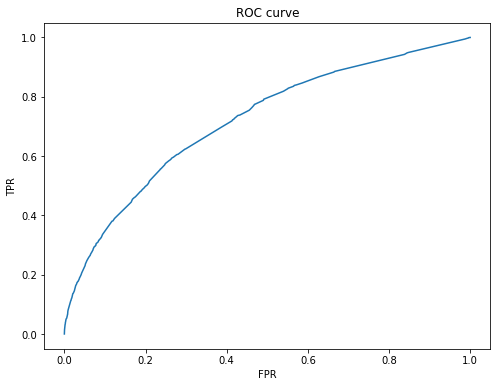

In [103]:
print("accuracy:", accuracy_score(y_test, y_pred))
print("roc_auc:", roc_auc_score(y_test, preds))

fpr, tpr, _ = roc_curve(y_test, preds, drop_intermediate=False)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

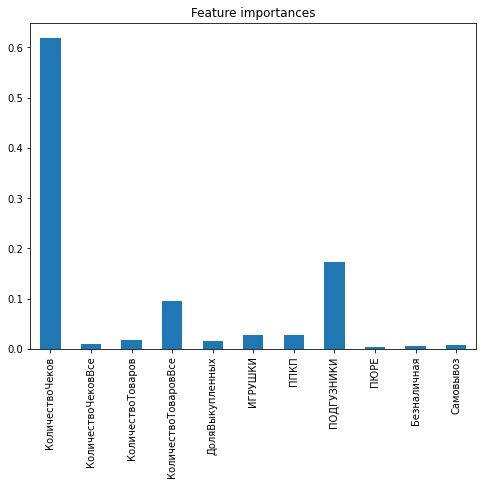

In [106]:
importance = pd.Series(clf.feature_importances_, index=X_train.columns)

importance.plot.bar()
plt.title('Feature importances')
plt.show()

## Смотрим на дерево

In [107]:
# from sklearn.tree import export_graphviz
# from six import StringIO
# from IPython.display import Image  
# import pydotplus

# dot_data = StringIO()

# export_graphviz(clf, out_file=dot_data,
#                 filled=True, rounded=True,
#                 special_characters=True,
#                 feature_names = X_train.columns,
#                 class_names=['0','1'])

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('tree.png')

# Image(graph.create_png())

## Обучаем случайный лес

In [108]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    max_depth=5,
#     min_samples_leaf=100,
    random_state=42,
)
clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)
preds = probs[:,1]

## Считаем метрики случайного леса

accuracy: 0.8677306250755652
roc_auc: 0.7262193798875811


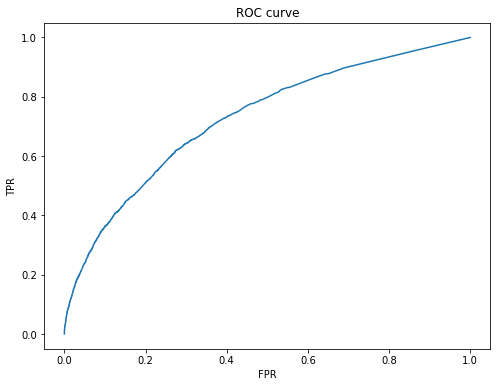

In [109]:
print("accuracy:", accuracy_score(y_test, y_pred))
print("roc_auc:", roc_auc_score(y_test, preds))

fpr, tpr, _ = roc_curve(y_test, preds, drop_intermediate=False)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

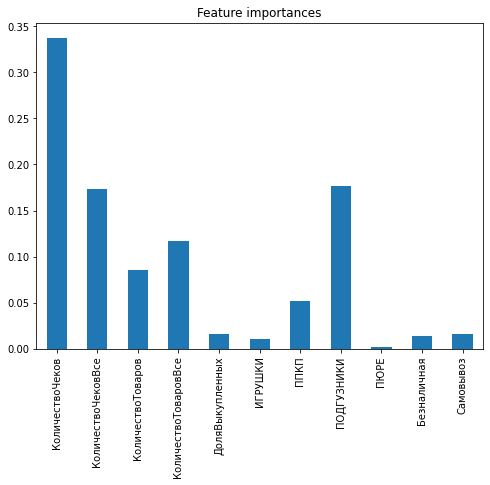

In [110]:
importance = pd.Series(clf.feature_importances_, index=X_train.columns)

importance.plot.bar()
plt.title('Feature importances')
plt.show()

## Обучаем логрег

In [129]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        max_iter=10000,
    )),
])

clf = pipeline.fit(X_train, y_train)

y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)
preds = probs[:,1]

## Метрики логрега

accuracy: 0.8678515294402128
roc_auc: 0.7163226586880203


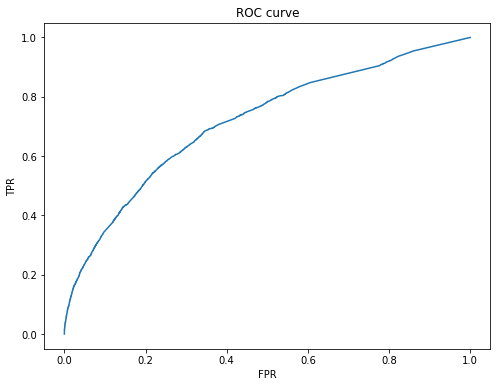

In [130]:
print("accuracy:", accuracy_score(y_test, y_pred))
print("roc_auc:", roc_auc_score(y_test, preds))

fpr, tpr, _ = roc_curve(y_test, preds, drop_intermediate=False)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

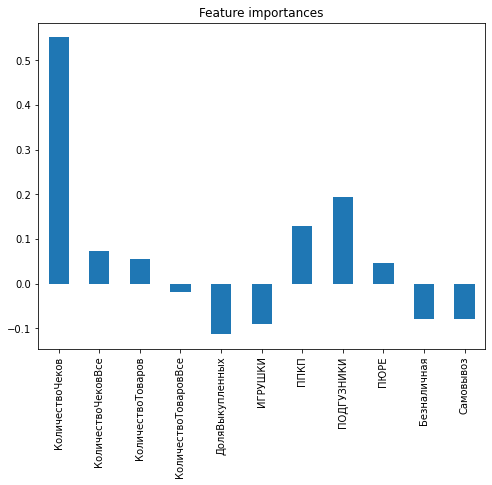

In [132]:
importance = pd.Series(clf.named_steps['model'].coef_[0], index=X_train.columns)

importance.plot.bar()
plt.title('Feature importances')
plt.show()

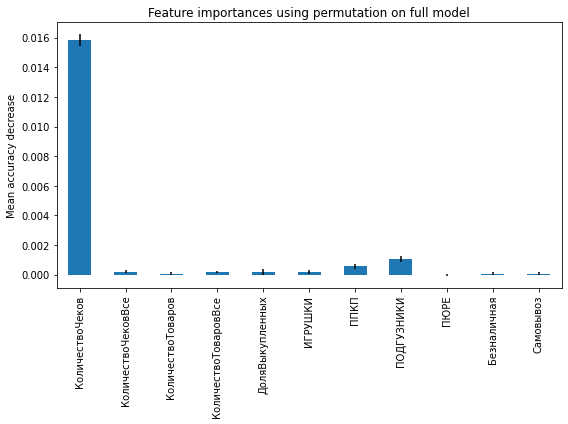

In [133]:
from sklearn.inspection import permutation_importance

# plt.rcParams["figure.figsize"] = (24,18)

result = permutation_importance(clf, X_train, y_train, n_repeats=16,
                                random_state=42)

# logreg_importances = pd.Series(result.importances_mean)
logreg_importances = pd.Series(result.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
logreg_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# plt.rcParams["figure.figsize"] = (8,6)

## Обучаем XGBoost

In [216]:
import xgboost

clf = xgboost.XGBClassifier(
    use_label_encoder=False,
    n_estimators=100,
    objective='binary:logistic',
    max_depth=3,
    eta=0.1,
)
clf.fit(
    X_train, y_train,
    early_stopping_rounds=10,
    eval_metric='auc',
    eval_set=[(X_test, y_test)],
    verbose=True,
)

y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)
preds = probs[:,1]

[0]	validation_0-auc:0.70311
[1]	validation_0-auc:0.70809
[2]	validation_0-auc:0.70827
[3]	validation_0-auc:0.71528
[4]	validation_0-auc:0.71607
[5]	validation_0-auc:0.71811
[6]	validation_0-auc:0.71808
[7]	validation_0-auc:0.71812
[8]	validation_0-auc:0.72119
[9]	validation_0-auc:0.72155
[10]	validation_0-auc:0.72151
[11]	validation_0-auc:0.72159
[12]	validation_0-auc:0.72163
[13]	validation_0-auc:0.72188
[14]	validation_0-auc:0.72543
[15]	validation_0-auc:0.72578
[16]	validation_0-auc:0.72617
[17]	validation_0-auc:0.72643
[18]	validation_0-auc:0.72669
[19]	validation_0-auc:0.72709
[20]	validation_0-auc:0.72680
[21]	validation_0-auc:0.72702
[22]	validation_0-auc:0.72671
[23]	validation_0-auc:0.72734
[24]	validation_0-auc:0.72748
[25]	validation_0-auc:0.72745
[26]	validation_0-auc:0.72742
[27]	validation_0-auc:0.72759
[28]	validation_0-auc:0.72751
[29]	validation_0-auc:0.72749
[30]	validation_0-auc:0.72748
[31]	validation_0-auc:0.72750
[32]	validation_0-auc:0.72737
[33]	validation_0-au

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


## Метрики XGBoost

accuracy: 0.8679724338048603
roc_auc: 0.7275865571900529


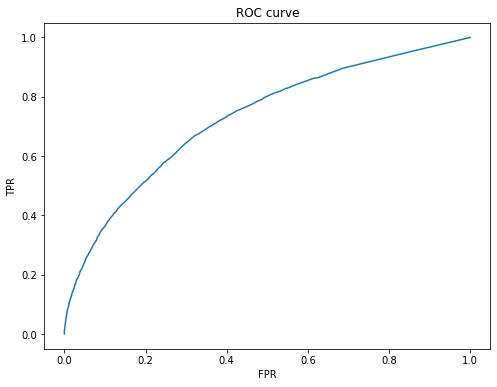

In [217]:
print("accuracy:", accuracy_score(y_test, y_pred))
print("roc_auc:", roc_auc_score(y_test, preds))

fpr, tpr, _ = roc_curve(y_test, preds, drop_intermediate=False)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Подбор гиперпараметров XGBoost

In [253]:
from hyperopt import hp, Trials, fmin, tpe, STATUS_OK

params = {
    "learning_rate":    hp.choice('learning_rate', np.arange(0.05, 0.21, 0.05)),
    "max_depth":        hp.choice('max_depth', np.arange(1, 5, 1, dtype=int)),
    "min_child_weight": hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    "gamma":            hp.choice('gamma', np.arange(0.0, 0.5, 0.1)),
    "colsample_bytree": hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    "subsample":        hp.choice('subsample', np.arange(0.8, 1.01, 0.05)),
    "n_estimators":     1000,
}

fit_params = {
    'eval_metric':           'auc',
    'eval_set':              [(X_train, y_train), (X_test, y_test)],
    'early_stopping_rounds': 10,
    'verbose':               False,
}

def objective(space):
    clf = xgboost.XGBClassifier(
        verbosity         = 0,
        use_label_encoder = False,
        learning_rate     = space['learning_rate'],
        max_depth         = space['max_depth'],
        min_child_weight  = space['min_child_weight'],
        gamma             = space['gamma'],
        colsample_bytree  = space['colsample_bytree'],
        subsample         = space['subsample'],
        n_estimators      = space['n_estimators'], 
    )
    print(f'''
------------------------
learning_rate    = {space['learning_rate']},
max_depth        = {space['max_depth']},
min_child_weight = {space['min_child_weight']},
gamma            = {space['gamma']},
colsample_bytree = {space['colsample_bytree']},
subsample        = {space['subsample']},
n_estimators     = {space['n_estimators']},
------------------------
''')
    
    clf.fit(X_train, y_train, **fit_params)
    
    y_pred = clf.predict(X_test)
    preds = clf.predict_proba(X_test)[:,1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, preds)

    print(f"accuracy = {accuracy}, roc_auc = {roc_auc}")
    
    return {'loss': -roc_auc, 'status': STATUS_OK}

In [254]:
# trials = Trials()

# best_hyperparams = fmin(
#     fn = objective,
#     space = params,
#     algo = tpe.suggest,
#     max_evals = 1000,
#     trials = trials,
# )
# best_hyperparams

                                                       
------------------------
learning_rate    = 0.05,
max_depth        = 3,
min_child_weight = 7,
gamma            = 0.4,
colsample_bytree = 0.7000000000000002,
subsample        = 0.8,
n_estimators     = 1000,
------------------------

accuracy = 0.8681336396243904, roc_auc = 0.727114184327306
                                                                                 
------------------------
learning_rate    = 0.2,
max_depth        = 1,
min_child_weight = 1,
gamma            = 0.1,
colsample_bytree = 0.6000000000000001,
subsample        = 0.8500000000000001,
n_estimators     = 1000,
------------------------

  1%|          | 1/100 [00:02<04:34,  2.77s/trial, best loss: -0.727114184327306]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8675694192560351, roc_auc = 0.725047219984                          
                                                                                 
------------------------
learning_rate    = 0.1,
max_depth        = 4,
min_child_weight = 1,
gamma            = 0.1,
colsample_bytree = 0.3,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

  2%|▏         | 2/100 [00:03<02:52,  1.76s/trial, best loss: -0.727114184327306]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8666827872486197, roc_auc = 0.726049956013465                       
                                                                                 
------------------------
learning_rate    = 0.2,
max_depth        = 4,
min_child_weight = 2,
gamma            = 0.2,
colsample_bytree = 0.5,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

  3%|▎         | 3/100 [00:08<04:44,  2.94s/trial, best loss: -0.727114184327306]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8674082134365051, roc_auc = 0.7266551757415575                      
                                                                                 
------------------------
learning_rate    = 0.1,
max_depth        = 4,
min_child_weight = 4,
gamma            = 0.2,
colsample_bytree = 0.5,
subsample        = 0.8500000000000001,
n_estimators     = 1000,
------------------------

  4%|▍         | 4/100 [00:08<03:19,  2.08s/trial, best loss: -0.727114184327306]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8680127352597429, roc_auc = 0.726202977331141                       
                                                                                 
------------------------
learning_rate    = 0.05,
max_depth        = 1,
min_child_weight = 3,
gamma            = 0.2,
colsample_bytree = 0.3,
subsample        = 0.8500000000000001,
n_estimators     = 1000,
------------------------

  5%|▌         | 5/100 [00:09<02:39,  1.68s/trial, best loss: -0.727114184327306]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8676097207109177, roc_auc = 0.7243417854806952                      
                                                                                 
------------------------
learning_rate    = 0.05,
max_depth        = 1,
min_child_weight = 7,
gamma            = 0.30000000000000004,
colsample_bytree = 0.4,
subsample        = 1.0000000000000002,
n_estimators     = 1000,
------------------------

  6%|▌         | 6/100 [00:13<03:32,  2.26s/trial, best loss: -0.727114184327306]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8642243985007859, roc_auc = 0.7242915742794405                      
                                                                                 
------------------------
learning_rate    = 0.2,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.8,
n_estimators     = 1000,
------------------------

  7%|▋         | 7/100 [00:14<02:59,  1.93s/trial, best loss: -0.727114184327306]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8677709265304477, roc_auc = 0.7267486703132664                      
                                                                                 
------------------------
learning_rate    = 0.1,
max_depth        = 2,
min_child_weight = 4,
gamma            = 0.4,
colsample_bytree = 0.5,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

  8%|▊         | 8/100 [00:16<03:09,  2.06s/trial, best loss: -0.727114184327306]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8677306250755652, roc_auc = 0.7268399501938105                      
                                                                                 
------------------------
learning_rate    = 0.2,
max_depth        = 2,
min_child_weight = 6,
gamma            = 0.1,
colsample_bytree = 0.5,
subsample        = 0.8500000000000001,
n_estimators     = 1000,
------------------------

  9%|▉         | 9/100 [00:19<03:10,  2.09s/trial, best loss: -0.727114184327306]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8680127352597429, roc_auc = 0.7261947345274615                      
                                                                                  
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 10%|█         | 10/100 [00:19<02:36,  1.73s/trial, best loss: -0.727114184327306]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8672067061620925, roc_auc = 0.727269918641659                        
                                                                                  
------------------------
learning_rate    = 0.05,
max_depth        = 2,
min_child_weight = 7,
gamma            = 0.4,
colsample_bytree = 0.5,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 11%|█         | 11/100 [00:21<02:35,  1.75s/trial, best loss: -0.727269918641659]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8678112279853303, roc_auc = 0.7255605715542077                       
                                                                                  
------------------------
learning_rate    = 0.05,
max_depth        = 2,
min_child_weight = 4,
gamma            = 0.0,
colsample_bytree = 0.4,
subsample        = 0.8500000000000001,
n_estimators     = 1000,
------------------------

 12%|█▏        | 12/100 [00:23<02:43,  1.86s/trial, best loss: -0.727269918641659]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8676097207109177, roc_auc = 0.7246252313452549                       
                                                                                  
------------------------
learning_rate    = 0.2,
max_depth        = 2,
min_child_weight = 2,
gamma            = 0.4,
colsample_bytree = 0.4,
subsample        = 0.8,
n_estimators     = 1000,
------------------------

 13%|█▎        | 13/100 [00:25<02:29,  1.72s/trial, best loss: -0.727269918641659]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8676500221658002, roc_auc = 0.7269735237546945                       
                                                                                  
------------------------
learning_rate    = 0.05,
max_depth        = 3,
min_child_weight = 5,
gamma            = 0.1,
colsample_bytree = 0.5,
subsample        = 1.0000000000000002,
n_estimators     = 1000,
------------------------

 14%|█▍        | 14/100 [00:26<02:23,  1.67s/trial, best loss: -0.727269918641659]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8674082134365051, roc_auc = 0.7271516126079931                       
                                                                                  
------------------------
learning_rate    = 0.2,
max_depth        = 4,
min_child_weight = 3,
gamma            = 0.1,
colsample_bytree = 0.5,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 15%|█▌        | 15/100 [00:30<03:06,  2.20s/trial, best loss: -0.727269918641659]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8675694192560351, roc_auc = 0.7272728807910921                       
                                                                                   
------------------------
learning_rate    = 0.15000000000000002,
max_depth        = 2,
min_child_weight = 4,
gamma            = 0.0,
colsample_bytree = 0.5,
subsample        = 1.0000000000000002,
n_estimators     = 1000,
------------------------

 16%|█▌        | 16/100 [00:31<02:33,  1.82s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8676500221658002, roc_auc = 0.7264314434875317                        
                                                                                   
------------------------
learning_rate    = 0.15000000000000002,
max_depth        = 2,
min_child_weight = 4,
gamma            = 0.30000000000000004,
colsample_bytree = 0.6000000000000001,
subsample        = 1.0000000000000002,
n_estimators     = 1000,
------------------------

 17%|█▋        | 17/100 [00:32<02:14,  1.62s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8676500221658002, roc_auc = 0.7266467599151307                        
                                                                                   
------------------------
learning_rate    = 0.15000000000000002,
max_depth        = 4,
min_child_weight = 5,
gamma            = 0.4,
colsample_bytree = 0.7000000000000002,
subsample        = 1.0000000000000002,
n_estimators     = 1000,
------------------------

 18%|█▊        | 18/100 [00:33<01:58,  1.45s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8668842945230323, roc_auc = 0.7267257828642589                        
                                                                                   
------------------------
learning_rate    = 0.05,
max_depth        = 2,
min_child_weight = 6,
gamma            = 0.4,
colsample_bytree = 0.3,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 19%|█▉        | 19/100 [00:34<01:55,  1.43s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8652319348728489, roc_auc = 0.7239784584741809                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 20%|██        | 20/100 [00:35<01:42,  1.28s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8672067061620925, roc_auc = 0.727269918641659                         
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 4,
min_child_weight = 3,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 21%|██        | 21/100 [00:38<02:06,  1.60s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8670455003425623, roc_auc = 0.7269372374241392                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.1,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 22%|██▏       | 22/100 [00:41<02:48,  2.16s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8676903236206827, roc_auc = 0.7269725133018503                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.1,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 23%|██▎       | 23/100 [00:42<02:16,  1.77s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8672067061620925, roc_auc = 0.7272610737188191                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 4,
min_child_weight = 3,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 24%|██▍       | 24/100 [00:44<02:24,  1.90s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8670455003425623, roc_auc = 0.7269372374241392                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.30000000000000004,
colsample_bytree = 0.3,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 25%|██▌       | 25/100 [00:46<02:28,  1.97s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8672067061620925, roc_auc = 0.7253249214933506                        
                                                                                   
------------------------
learning_rate    = 0.15000000000000002,
max_depth        = 4,
min_child_weight = 2,
gamma            = 0.0,
colsample_bytree = 0.5,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 26%|██▌       | 26/100 [00:48<02:20,  1.90s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.86732761052674, roc_auc = 0.7271772338164072                          
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 1,
min_child_weight = 3,
gamma            = 0.1,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 27%|██▋       | 27/100 [00:50<02:17,  1.88s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8677709265304477, roc_auc = 0.72546511144409                          
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 6,
gamma            = 0.1,
colsample_bytree = 0.4,
subsample        = 0.8,
n_estimators     = 1000,
------------------------

 28%|██▊       | 28/100 [00:52<02:28,  2.06s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8679321323499778, roc_auc = 0.7265684221360819                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 4,
min_child_weight = 1,
gamma            = 0.0,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 29%|██▉       | 29/100 [00:56<02:59,  2.52s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8671261032523274, roc_auc = 0.72650162151382                          
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 5,
gamma            = 0.30000000000000004,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 30%|███       | 30/100 [00:57<02:33,  2.19s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8674485148913876, roc_auc = 0.7270295692829865                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 4,
min_child_weight = 1,
gamma            = 0.2,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 31%|███       | 31/100 [01:00<02:32,  2.22s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8669245959779148, roc_auc = 0.7266597435420853                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 1,
min_child_weight = 7,
gamma            = 0.1,
colsample_bytree = 0.5,
subsample        = 0.8,
n_estimators     = 1000,
------------------------

 32%|███▏      | 32/100 [01:01<02:20,  2.07s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8642243985007859, roc_auc = 0.7233591477735515                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 4,
min_child_weight = 3,
gamma            = 0.1,
colsample_bytree = 0.3,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 33%|███▎      | 33/100 [01:03<02:01,  1.82s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.866239471244912, roc_auc = 0.7249542306387131                         
                                                                                   
------------------------
learning_rate    = 0.15000000000000002,
max_depth        = 3,
min_child_weight = 2,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 34%|███▍      | 34/100 [01:04<01:56,  1.76s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8679724338048603, roc_auc = 0.726396513655315                         
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 4,
min_child_weight = 1,
gamma            = 0.1,
colsample_bytree = 0.5,
subsample        = 0.8500000000000001,
n_estimators     = 1000,
------------------------

 35%|███▌      | 35/100 [01:05<01:40,  1.55s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8681336396243904, roc_auc = 0.7261816194032192                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 1,
min_child_weight = 3,
gamma            = 0.2,
colsample_bytree = 0.4,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 36%|███▌      | 36/100 [01:06<01:26,  1.36s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8672067061620925, roc_auc = 0.7247130853754031                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 7,
gamma            = 0.2,
colsample_bytree = 0.3,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 37%|███▋      | 37/100 [01:07<01:11,  1.13s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8667230887035022, roc_auc = 0.7260358304363789                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 4,
min_child_weight = 3,
gamma            = 0.30000000000000004,
colsample_bytree = 0.5,
subsample        = 0.8,
n_estimators     = 1000,
------------------------

 38%|███▊      | 38/100 [01:09<01:36,  1.56s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8674485148913876, roc_auc = 0.7270632187468735                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 1,
min_child_weight = 6,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.8500000000000001,
n_estimators     = 1000,
------------------------

 39%|███▉      | 39/100 [01:10<01:22,  1.35s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8676097207109177, roc_auc = 0.7255995916441697                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.1,
colsample_bytree = 0.5,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 40%|████      | 40/100 [01:12<01:33,  1.56s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8676097207109177, roc_auc = 0.726400749252168                         
                                                                                   
------------------------
learning_rate    = 0.05,
max_depth        = 4,
min_child_weight = 5,
gamma            = 0.2,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 41%|████      | 41/100 [01:14<01:31,  1.55s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8675694192560351, roc_auc = 0.7268170489029832                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 2,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.8500000000000001,
n_estimators     = 1000,
------------------------

 42%|████▏     | 42/100 [01:18<02:09,  2.23s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8674888163462701, roc_auc = 0.7268567057166548                        
                                                                                   
------------------------
learning_rate    = 0.15000000000000002,
max_depth        = 4,
min_child_weight = 3,
gamma            = 0.4,
colsample_bytree = 0.4,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 43%|████▎     | 43/100 [01:19<01:54,  2.00s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8668036916132672, roc_auc = 0.7262917864468541                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 1,
min_child_weight = 7,
gamma            = 0.1,
colsample_bytree = 0.5,
subsample        = 1.0000000000000002,
n_estimators     = 1000,
------------------------

 44%|████▍     | 44/100 [01:21<01:48,  1.94s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8677709265304477, roc_auc = 0.7256519967738594                        
                                                                                   
------------------------
learning_rate    = 0.05,
max_depth        = 3,
min_child_weight = 4,
gamma            = 0.0,
colsample_bytree = 0.5,
subsample        = 0.8,
n_estimators     = 1000,
------------------------

 45%|████▌     | 45/100 [01:23<01:49,  1.99s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8676903236206827, roc_auc = 0.725294414122554                         
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 4,
min_child_weight = 1,
gamma            = 0.30000000000000004,
colsample_bytree = 0.3,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 46%|████▌     | 46/100 [01:24<01:35,  1.77s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8670455003425623, roc_auc = 0.7255828914886042                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.4,
colsample_bytree = 0.7000000000000002,
subsample        = 1.0000000000000002,
n_estimators     = 1000,
------------------------

 47%|████▋     | 47/100 [01:27<01:48,  2.04s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8675694192560351, roc_auc = 0.7269406217490757                        
                                                                                   
------------------------
learning_rate    = 0.05,
max_depth        = 2,
min_child_weight = 6,
gamma            = 0.0,
colsample_bytree = 0.4,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 48%|████▊     | 48/100 [01:28<01:32,  1.77s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8675291178011526, roc_auc = 0.7239732816335828                        
                                                                                   
------------------------
learning_rate    = 0.15000000000000002,
max_depth        = 4,
min_child_weight = 5,
gamma            = 0.2,
colsample_bytree = 0.5,
subsample        = 0.8500000000000001,
n_estimators     = 1000,
------------------------

 49%|████▉     | 49/100 [01:29<01:17,  1.51s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8675291178011526, roc_auc = 0.7264344540833341                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 1,
min_child_weight = 4,
gamma            = 0.1,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 50%|█████     | 50/100 [01:30<01:06,  1.33s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8684963527183331, roc_auc = 0.7250184705243155                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 2,
min_child_weight = 3,
gamma            = 0.0,
colsample_bytree = 0.6000000000000001,
subsample        = 0.8,
n_estimators     = 1000,
------------------------

 51%|█████     | 51/100 [01:32<01:10,  1.45s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8674485148913876, roc_auc = 0.7269439991531021                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 2,
gamma            = 0.4,
colsample_bytree = 0.5,
subsample        = 1.0000000000000002,
n_estimators     = 1000,
------------------------

 52%|█████▏    | 52/100 [01:33<01:06,  1.38s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8674485148913876, roc_auc = 0.7267245371004785                        
                                                                                   
------------------------
learning_rate    = 0.05,
max_depth        = 4,
min_child_weight = 3,
gamma            = 0.30000000000000004,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 53%|█████▎    | 53/100 [01:35<01:18,  1.67s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8676903236206827, roc_auc = 0.7270300537466788                        
                                                                                   
------------------------
learning_rate    = 0.15000000000000002,
max_depth        = 3,
min_child_weight = 7,
gamma            = 0.1,
colsample_bytree = 0.3,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 54%|█████▍    | 54/100 [01:38<01:29,  1.94s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.86716640470721, roc_auc = 0.7258565857911284                          
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 2,
min_child_weight = 3,
gamma            = 0.0,
colsample_bytree = 0.4,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 55%|█████▌    | 55/100 [01:39<01:24,  1.89s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8681336396243904, roc_auc = 0.7265834128269044                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 4,
min_child_weight = 6,
gamma            = 0.1,
colsample_bytree = 0.5,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 56%|█████▌    | 56/100 [01:41<01:22,  1.87s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8681739410792729, roc_auc = 0.7264707265720696                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 3,
min_child_weight = 4,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.8500000000000001,
n_estimators     = 1000,
------------------------

 57%|█████▋    | 57/100 [01:43<01:18,  1.82s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8678515294402128, roc_auc = 0.7268151525736732                        
                                                                                   
------------------------
learning_rate    = 0.05,
max_depth        = 1,
min_child_weight = 5,
gamma            = 0.4,
colsample_bytree = 0.7000000000000002,
subsample        = 1.0000000000000002,
n_estimators     = 1000,
------------------------

 58%|█████▊    | 58/100 [01:44<01:08,  1.63s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8642243985007859, roc_auc = 0.7239694543704134                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 2,
min_child_weight = 1,
gamma            = 0.2,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 59%|█████▉    | 59/100 [01:45<01:02,  1.52s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8679724338048603, roc_auc = 0.7266671350738478                        
                                                                                   
------------------------
learning_rate    = 0.15000000000000002,
max_depth        = 4,
min_child_weight = 3,
gamma            = 0.30000000000000004,
colsample_bytree = 0.5,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 60%|██████    | 60/100 [01:47<01:01,  1.54s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.86716640470721, roc_auc = 0.7265901537931375                          
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.1,
colsample_bytree = 0.3,
subsample        = 0.8,
n_estimators     = 1000,
------------------------

 61%|██████    | 61/100 [01:48<00:52,  1.33s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8669648974327974, roc_auc = 0.7260988245582011                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 4,
min_child_weight = 2,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 62%|██████▏   | 62/100 [01:50<00:53,  1.42s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8675291178011526, roc_auc = 0.7268354516023816                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 3,
min_child_weight = 7,
gamma            = 0.1,
colsample_bytree = 0.4,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 63%|██████▎   | 63/100 [01:51<00:53,  1.44s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.86732761052674, roc_auc = 0.7265831636741482                          
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 1,
min_child_weight = 3,
gamma            = 0.0,
colsample_bytree = 0.5,
subsample        = 0.8500000000000001,
n_estimators     = 1000,
------------------------

 64%|██████▍   | 64/100 [01:52<00:49,  1.38s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8677306250755652, roc_auc = 0.7259628009952156                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 65%|██████▌   | 65/100 [01:55<01:03,  1.82s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8672067061620925, roc_auc = 0.727269918641659                         
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 66%|██████▌   | 66/100 [01:57<01:00,  1.78s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8672067061620925, roc_auc = 0.727269918641659                         
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 67%|██████▋   | 67/100 [01:59<01:06,  2.01s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8672067061620925, roc_auc = 0.727269918641659                         
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 68%|██████▊   | 68/100 [02:02<01:14,  2.34s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8672067061620925, roc_auc = 0.727269918641659                         
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 69%|██████▉   | 69/100 [02:04<01:06,  2.14s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8672067061620925, roc_auc = 0.727269918641659                         
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 70%|███████   | 70/100 [02:08<01:16,  2.57s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8672067061620925, roc_auc = 0.727269918641659                         
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 3,
gamma            = 0.0,
colsample_bytree = 0.7000000000000002,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 71%|███████   | 71/100 [02:09<01:06,  2.28s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8672067061620925, roc_auc = 0.727269918641659                         
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 6,
gamma            = 0.0,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 72%|███████▏  | 72/100 [02:11<01:00,  2.16s/trial, best loss: -0.7272728807910921]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8672067061620925, roc_auc = 0.7272787289599495                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 6,
gamma            = 0.1,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 73%|███████▎  | 73/100 [02:13<00:54,  2.00s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8672067061620925, roc_auc = 0.7272787289599495                        
                                                                                   
------------------------
learning_rate    = 0.15000000000000002,
max_depth        = 4,
min_child_weight = 6,
gamma            = 0.1,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 74%|███████▍  | 74/100 [02:15<00:54,  2.11s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8679321323499778, roc_auc = 0.7269617997333401                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 2,
min_child_weight = 6,
gamma            = 0.1,
colsample_bytree = 0.6000000000000001,
subsample        = 1.0000000000000002,
n_estimators     = 1000,
------------------------

 75%|███████▌  | 75/100 [02:16<00:43,  1.74s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.86716640470721, roc_auc = 0.7263198645782794                          
                                                                                   
------------------------
learning_rate    = 0.05,
max_depth        = 3,
min_child_weight = 6,
gamma            = 0.1,
colsample_bytree = 0.6000000000000001,
subsample        = 0.8,
n_estimators     = 1000,
------------------------

 76%|███████▌  | 76/100 [02:18<00:40,  1.67s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8674888163462701, roc_auc = 0.7269372028195898                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 4,
min_child_weight = 6,
gamma            = 0.1,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 77%|███████▋  | 77/100 [02:21<00:47,  2.07s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8677709265304477, roc_auc = 0.7267294647883207                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 3,
min_child_weight = 6,
gamma            = 0.1,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 78%|███████▊  | 78/100 [02:22<00:42,  1.94s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8675694192560351, roc_auc = 0.7263217263030399                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 1,
min_child_weight = 6,
gamma            = 0.1,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 79%|███████▉  | 79/100 [02:23<00:34,  1.63s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8642243985007859, roc_auc = 0.7244832696415838                        
                                                                                   
------------------------
learning_rate    = 0.15000000000000002,
max_depth        = 3,
min_child_weight = 6,
gamma            = 0.1,
colsample_bytree = 0.6000000000000001,
subsample        = 0.8500000000000001,
n_estimators     = 1000,
------------------------

 80%|████████  | 80/100 [02:25<00:31,  1.60s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.868254543989038, roc_auc = 0.726229733568777                          
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 4,
min_child_weight = 6,
gamma            = 0.2,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 81%|████████  | 81/100 [02:26<00:26,  1.39s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8664812799742071, roc_auc = 0.7268143774317655                        
                                                                                   
------------------------
learning_rate    = 0.05,
max_depth        = 2,
min_child_weight = 6,
gamma            = 0.4,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 82%|████████▏ | 82/100 [02:27<00:24,  1.33s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8681336396243904, roc_auc = 0.726574713243172                         
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 6,
gamma            = 0.30000000000000004,
colsample_bytree = 0.6000000000000001,
subsample        = 1.0000000000000002,
n_estimators     = 1000,
------------------------

 83%|████████▎ | 83/100 [02:30<00:30,  1.82s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8674082134365051, roc_auc = 0.7266034142564877                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 4,
min_child_weight = 1,
gamma            = 0.1,
colsample_bytree = 0.6000000000000001,
subsample        = 0.8,
n_estimators     = 1000,
------------------------

 84%|████████▍ | 84/100 [02:32<00:29,  1.85s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8676500221658002, roc_auc = 0.7266919742194445                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 3,
min_child_weight = 5,
gamma            = 0.1,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 85%|████████▌ | 85/100 [02:33<00:26,  1.78s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8676097207109177, roc_auc = 0.7267775720329686                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 1,
min_child_weight = 4,
gamma            = 0.2,
colsample_bytree = 0.5,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 86%|████████▌ | 86/100 [02:34<00:22,  1.63s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8642243985007859, roc_auc = 0.7242093054235738                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 4,
min_child_weight = 6,
gamma            = 0.4,
colsample_bytree = 0.6000000000000001,
subsample        = 0.8500000000000001,
n_estimators     = 1000,
------------------------

 87%|████████▋ | 87/100 [02:35<00:18,  1.43s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8663603756095595, roc_auc = 0.7261614518717988                        
                                                                                   
------------------------
learning_rate    = 0.15000000000000002,
max_depth        = 3,
min_child_weight = 2,
gamma            = 0.30000000000000004,
colsample_bytree = 0.3,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 88%|████████▊ | 88/100 [02:37<00:16,  1.39s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.86716640470721, roc_auc = 0.7257120771926175                          
                                                                                   
------------------------
learning_rate    = 0.05,
max_depth        = 2,
min_child_weight = 7,
gamma            = 0.1,
colsample_bytree = 0.5,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 89%|████████▉ | 89/100 [02:39<00:18,  1.71s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8678112279853303, roc_auc = 0.7255605715542077                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 4,
min_child_weight = 6,
gamma            = 0.1,
colsample_bytree = 0.4,
subsample        = 1.0000000000000002,
n_estimators     = 1000,
------------------------

 90%|█████████ | 90/100 [02:41<00:16,  1.61s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8674082134365051, roc_auc = 0.726411670447975                         
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 3,
min_child_weight = 5,
gamma            = 0.1,
colsample_bytree = 0.6000000000000001,
subsample        = 0.8,
n_estimators     = 1000,
------------------------

 91%|█████████ | 91/100 [02:43<00:16,  1.85s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.86732761052674, roc_auc = 0.7264307583174526                          
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 1,
min_child_weight = 1,
gamma            = 0.2,
colsample_bytree = 0.5,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 92%|█████████▏| 92/100 [02:44<00:12,  1.61s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8642243985007859, roc_auc = 0.724509652150086                         
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 3,
min_child_weight = 4,
gamma            = 0.4,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 93%|█████████▎| 93/100 [02:45<00:09,  1.36s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8678515294402128, roc_auc = 0.7270894974417271                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 4,
min_child_weight = 6,
gamma            = 0.30000000000000004,
colsample_bytree = 0.3,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 94%|█████████▍| 94/100 [02:47<00:09,  1.52s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8669648974327974, roc_auc = 0.7246364916656465                        
                                                                                   
------------------------
learning_rate    = 0.15000000000000002,
max_depth        = 2,
min_child_weight = 2,
gamma            = 0.1,
colsample_bytree = 0.5,
subsample        = 0.8500000000000001,
n_estimators     = 1000,
------------------------

 95%|█████████▌| 95/100 [02:48<00:07,  1.54s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8685366541732157, roc_auc = 0.724958590811944                         
                                                                                   
------------------------
learning_rate    = 0.05,
max_depth        = 3,
min_child_weight = 6,
gamma            = 0.1,
colsample_bytree = 0.4,
subsample        = 0.9000000000000001,
n_estimators     = 1000,
------------------------

 96%|█████████▌| 96/100 [02:49<00:05,  1.28s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8679321323499778, roc_auc = 0.7251766063944003                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 4,
min_child_weight = 7,
gamma            = 0.2,
colsample_bytree = 0.6000000000000001,
subsample        = 0.9500000000000002,
n_estimators     = 1000,
------------------------

 97%|█████████▋| 97/100 [02:51<00:04,  1.49s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8672067061620925, roc_auc = 0.7271281091980056                        
                                                                                   
------------------------
learning_rate    = 0.2,
max_depth        = 3,
min_child_weight = 1,
gamma            = 0.1,
colsample_bytree = 0.5,
subsample        = 1.0000000000000002,
n_estimators     = 1000,
------------------------

 98%|█████████▊| 98/100 [02:52<00:02,  1.47s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8667230887035022, roc_auc = 0.7262094622237084                        
                                                                                   
------------------------
learning_rate    = 0.1,
max_depth        = 1,
min_child_weight = 6,
gamma            = 0.4,
colsample_bytree = 0.6000000000000001,
subsample        = 0.8,
n_estimators     = 1000,
------------------------

 99%|█████████▉| 99/100 [02:54<00:01,  1.41s/trial, best loss: -0.7272787289599495]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



accuracy = 0.8675694192560351, roc_auc = 0.7259339754055224                        
100%|██████████| 100/100 [02:56<00:00,  1.77s/trial, best loss: -0.7272787289599495]


/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



In [255]:
best_hyperparams

{'colsample_bytree': 3,
 'gamma': 0,
 'learning_rate': 1,
 'max_depth': 2,
 'min_child_weight': 5,
 'subsample': 3}

In [258]:
# # best roc_auc: 0.7272787289599495
# # accuracy: 0.8672067061620925
# clf = xgboost.XGBClassifier(
#     verbosity         = 0,
#     use_label_encoder = False,
#     learning_rate     = 0.1,
#     max_depth         = 3,
#     min_child_weight  = 6,
#     gamma             = 0.0,
#     colsample_bytree  = 0.6000000000000001,
#     subsample         = 0.9500000000000002,
#     n_estimators      = 1000,
# )

# best accuracy: 0.8685366541732157
# roc_auc: 0.7245468451198367
clf = xgboost.XGBClassifier(
    verbosity         = 0,
    use_label_encoder = False,
    learning_rate     = 0.1,
    max_depth         = 2,
    min_child_weight  = 5,
    gamma             = 0.0,
    colsample_bytree  = 0.6000000000000001,
    subsample         = 0.8,
    n_estimators      = 1000,
)

clf.fit(X_train, y_train, **fit_params)

y_pred = clf.predict(X_test)
preds = clf.predict_proba(X_test)[:,1]

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


accuracy: 0.8685366541732157
roc_auc: 0.7245468451198367


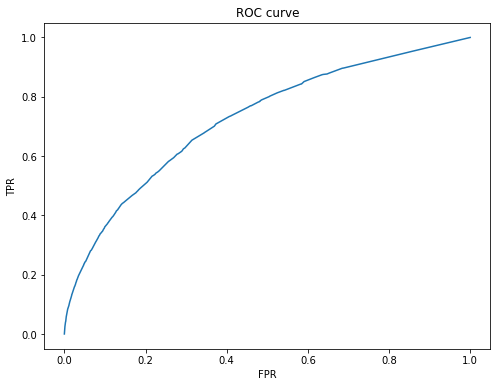

In [259]:
print("accuracy:", accuracy_score(y_test, y_pred))
print("roc_auc:", roc_auc_score(y_test, preds))

fpr, tpr, _ = roc_curve(y_test, preds, drop_intermediate=False)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [272]:
b_all['ВероятностьОтклика'] = pd.Series(clf.predict_proba(b_all[important_features])[:,1], index=b_all.index)

In [280]:
b_all.to_csv('./data/preds.csv')